In [8]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from core.datasets import fetch_dataloader
from lescroartdata import fetch_dataloader_lesc
import core.utils.sync_batchnorm as sync_batchnorm
from core.eisen import EISEN
from core.raft import EvalRAFT
from types import SimpleNamespace
from collections import OrderedDict
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import numpy as np

%load_ext autoreload
%autoreload 2

/home/galdegh/.conda/envs/eisen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(30, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
args = SimpleNamespace(
        dataset='playroom',
        batch_size=2,
        num_workers=1,
        compute_flow=True,
        precompute_flow=False,
        flow_threshold=0.5
    )

In [ ]:
device = torch.device("cuda:1")
#device = torch.device("cpu")

In [ ]:
val_loader = fetch_dataloader(args)
model = EISEN(device=device)
raft_model = EvalRAFT(flow_threshold=args.flow_threshold, device=device)

In [ ]:
state_dict = torch.load('pretrained/tdw_playroom_128x128_ckpt.pth', map_location=device)

In [ ]:
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [ ]:
model.load_state_dict(new_state_dict)
model.eval()

In [ ]:
data_dict = next(iter(val_loader))
data_dict = {k: v.to(device) for k, v in data_dict.items() if not k == 'file_name'}

In [ ]:
data_dict['gt_segment'].shape

In [ ]:
data_dict['gt_segment'] = torch.randint(4, data_dict['gt_segment'].shape, dtype=torch.int64, device=device)

In [ ]:
with torch.no_grad():
       _, _, segment_target = raft_model(data_dict['img1'], data_dict['img2'])

In [ ]:
segment_target.shape

In [ ]:
segment_target.dtype

In [ ]:
tensor = torch.rand((3, 5), device=device) < 0.9

In [ ]:
tensor.dtype

In [ ]:
grid = make_grid(segment_target.type(torch.uint8)*255)

In [ ]:
show(grid)

In [ ]:
grid = make_grid(data_dict['img1'])

In [ ]:
show(grid)

In [ ]:
_, loss, metric, seg_out = model(data_dict, segment_target.detach(),
                                 get_segments=True, vis_segments=False)

In [ ]:
from glob import glob
import os

dataset_dir = '../Lescroart.etal.2018/'
dirlist = glob(os.path.join(dataset_dir, 'stimuli_trn_*'))

In [ ]:
file_list = []
for dir in dirlist:
    file_list.extend(glob(os.path.join(dir, 'fr*.png')))

In [ ]:
file_list

In [ ]:
def visualize_segments(seg_out, input):
    batch_size = len(seg_out[0])
    num_objects = len(seg_out[0][0])
    pred_obj_seg, gt_obj_seg, iou = seg_out
    fig, axs = plt.subplots(batch_size, num_objects + 1, 
                            figsize=(3*(num_objects + 1), 3*batch_size))
    
    for m in range(batch_size):
        axs[m, 0].imshow(input['img1'][m].permute(1, 2, 0).cpu())
        for n in range(num_objects):
            #if n + 1 <= len(pred_obj_seg[m]): 
            axs[m, n + 1].imshow(pred_obj_seg[m][n])
            
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            axs[i, j].set_axis_off()
    
    plt.show()

In [ ]:
visualize_segments(seg_out['pred_segment'], data_dict)

In [ ]:
segment_target.shape

## Lescroart data

In [ ]:
args = SimpleNamespace(batch_size=2)
lesc_loader = fetch_dataloader_lesc(args)

In [ ]:
len(lesc_loader)

In [ ]:
with torch.no_grad():
    data_dict_lesc = next(iter(lesc_loader))
    data_dict_lesc['gt_segment'] = torch.randint(4, (args.batch_size, 512, 512), dtype=torch.int64, device=device)
    data_dict_lesc = {k: v.to(device) for k, v in data_dict_lesc.items() if not k == 'file_name'}
    _, loss, metric, seg_out = model(data_dict_lesc, segment_target.detach(),
                                    get_segments=True, vis_segments=False)

In [ ]:
with torch.no_grad():
    _, loss, metric, seg_out = model(data_dict_lesc, segment_target.detach(),
                                    get_segments=True, vis_segments=False)

In [ ]:
visualize_segments(seg_out['pred_segment'], data_dict_lesc)

In [ ]:
for x in seg_out['pred_segment']:
    print(len(x[0]))

In [2]:
allstimuli = glob('../Run01/Stim*png')

In [12]:
len(allstimuli)

144

In [13]:
image = Image.open(allstimuli[90])

In [14]:
np.array(image).shape

(224, 224)

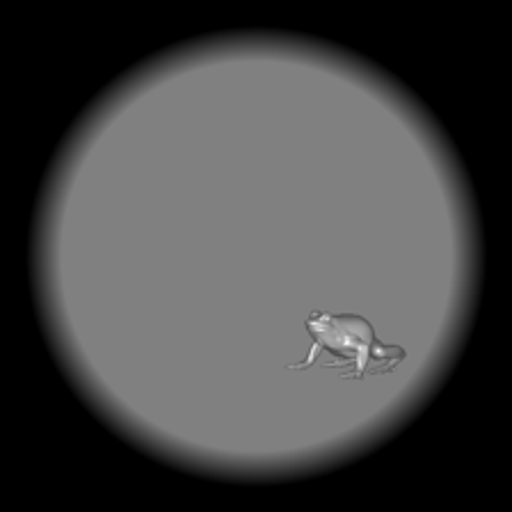

In [15]:
image_big = image.resize((512, 512))
image_big

In [3]:
allstimuli[0]

'../Run01/Stimulus053.png'

In [ ]:
visualize_segments(seg_out['pred_segment'], data_dict_lesc)

In [ ]:
type(seg_out['pred_segment'][0][0][0])

In [ ]:
len(seg_out['pred_segment'])

In [ ]:
for ps in seg_out['pred_segment']:
    print(len(ps))
    for i in ps:
        print(len(i))

In [ ]:
grid = make_grid(seg_out['pred_segment'])
show(grid)